# Fundamentals of Quantization

## Packages / Functions

We import the required packages first and put some functions here that we will frequently use.

In [1]:
# most common used packages for DSP, have a look into other scipy submodules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

# audio write and play stuff
import soundfile as sf  # requires 'pip install soundfile'
# last tested with soundfile-0.10.3

In [2]:
! pip install soundfile

In [3]:
def my_xcorr2(x, y, scaleopt='none'):
    r""" Cross Correlation function phixy[kappa] -> x[k+kappa] y

    input:
    x   input signal shifted by +kappa
    y   input signal
    scaleopt   scaling of CCF estimator
    output:
    kappa   sample index
    ccf   correlation result
    """
    N = len(x)
    M = len(y)
    kappa = np.arange(0, N+M-1) - (M-1)
    ccf = signal.correlate(x, y, mode='full', method='auto')
    if N == M:
        if scaleopt == 'none' or scaleopt == 'raw':
            ccf /= 1
        elif scaleopt == 'biased' or scaleopt == 'bias':
            ccf /= N
        elif scaleopt == 'unbiased' or scaleopt == 'unbias':
            ccf /= (N - np.abs(kappa))
        elif scaleopt == 'coeff' or scaleopt == 'normalized':
            ccf /= np.sqrt(np.sum(x**2) * np.sum(y**2))
        else:
            print('scaleopt unknown: we leave output unnormalized')
    return kappa, ccf

In [4]:
def uniform_midtread_quantizer(x, deltaQ):
    r"""uniform_midtread_quantizer from the lecture:
    https://github.com/spatialaudio/digital-signal-processing-lecture/blob/master/quantization/linear_uniform_quantization_error.ipynb
    commit: b00e23e
    note: we renamed the second input to deltaQ, since this is what the variable
    actually represents, i.e. the quantization step size

    input:
    x   input signal to be quantized
    deltaQ    quantization step size
    output:
    xq   quantized signal
    """
    # [-1...1) amplitude limiter
    x = np.copy(x)
    idx = np.where(x <= -1)
    x[idx] = -1
    idx = np.where(x > 1 - deltaQ)
    x[idx] = 1 - deltaQ
    # linear uniform quantization
    xq = deltaQ * np.floor(x/deltaQ + 1/2)
    return xq

In [5]:
def my_quant(x, Q):
    r"""Saturated uniform midtread quantizer

    input:
    x  input signal
    Q  number of quantization steps
    output:
    xq quantized signal

    Note: for even Q in order to retain midtread characteristics,
    we must omit one quantization step, either that for lowest or the highest
    amplitudes. Typically the highest signal amplitudes are saturated to
    the 'last' quantization step. Then, in the special case of log2(N)
    being an integer the quantization can be represented with bits.
    """
    tmp = Q//2  # integer div
    quant_steps = (np.arange(Q) - tmp) / tmp  # we don't use this

    # forward quantization, round() and inverse quantization
    xq = np.round(x*tmp) / tmp
    # always saturate to -1
    xq[xq < -1.] = -1.
    # saturate to ((Q-1) - (Q\2)) / (Q\2), note that \ is integer div
    tmp2 = ((Q-1) - tmp) / tmp  # for odd N this always yields 1
    xq[xq > tmp2] = tmp2
    return xq

## Quantization Process and Error

Quantization generates signals that have discrete values $x_q[k]$, $x_q(t)$ from signals with continuous values $x[k]$, $x(t)$.

For quantization, the signals can be both, discrete and continuous in time.
However, a signal that is discrete in time **and** discrete in value is termed a **digital** signal.
Only digital signals can be processed by computers.
Here the quantization of discrete-time signals is treated due to practical importance.

To describe quantization analytically, the model in the figure below is used.

<img src="QuantizationModel.png" alt="QuantizationModel.png" width="400"/>

The input and output signal differ by the so called quantization error (quantization noise) $e[k]$, that is defined as

\begin{equation}
e[k] = x_q[k] - x[k],
\end{equation}

so that the error constitutes an additive superposition

\begin{equation}
x[k] + e[k] = x_q[k]
\end{equation}


To use this error model, some assumption have to be made.
The quantization noise shall be uniformly distributed, which then can be modeled with the probability density function (PDF) $p_e(\theta) = \frac{1}{\Delta Q} \mathrm{rect}(\frac{\theta_e}{\Delta Q})$, where $\Delta Q$ denotes the quantization step size and $\theta_e$ the amplitudes of the quantization error signal.
This PDF is shown below.

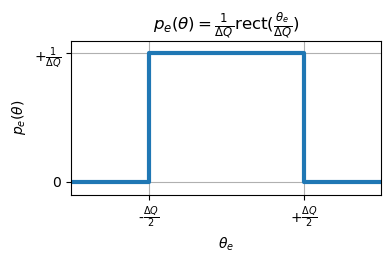

In [6]:
plt.figure(figsize=(4, 2))
plt.plot((-1, -1/2, -1/2, +1/2, +1/2, +1), (0, 0, 1, 1, 0, 0), lw=3)
plt.xlim(-1, 1)
plt.ylim(-0.1, 1.1)
plt.xticks((-0.5, +0.5), [r'-$\frac{\Delta Q}{2}$', r'+$\frac{\Delta Q}{2}$'])
plt.yticks((0, 1), [r'0', r'+$\frac{1}{\Delta Q}$'])
plt.xlabel(r'$\theta_e$')
plt.ylabel(r'$p_e(\theta)$')
plt.title(
    r'$p_e(\theta) = \frac{1}{\Delta Q} \mathrm{rect}(\frac{\theta_e}{\Delta Q})$')
plt.grid(True)

Furthermore, it is assumed that $e[k]$ is not correlated with $x[k]$.
That this is not necessarily the case can be demonstrated with the help of some straightforward examples.

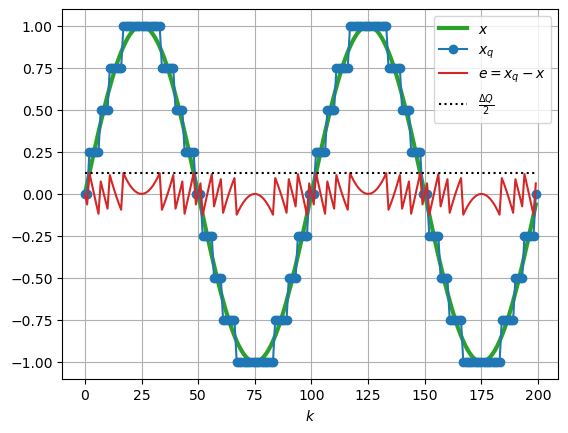

In [7]:
Q = 9  # odd, number of quantization steps
N = 100
k = np.arange(2*N)
x = np.sin(2*np.pi/N*k)
xq = my_quant(x, Q)
e = xq-x
# actually stem plots would be correct, for convenience we plot as line style
plt.plot(k, x, 'C2', lw=3, label=r'$x$')
plt.plot(k, xq, 'C0o-', label=r'$x_q$')
plt.plot(k, e, 'C3', label=r'$e=x_q-x$')
plt.plot(k, k*0+1/(Q-1), 'k:', label=r'$\frac{\Delta Q}{2}$')
plt.xlabel(r'$k$')
plt.legend()
plt.grid(True)

A sine signal is quantized with $Q=9$ quantization steps.
A periodicity of the quantization noise can be easily identified.
For odd $Q$, the maximum amplitude of the quantization error can be estimated to

$$\frac{\Delta Q}{2}=\frac{\frac{2}{Q-1}}{2}=\frac{1}{Q-1}=\frac{1}{8}=0.125.$$

The auto-correlation function of the error signal $e[k]$ is presented next.

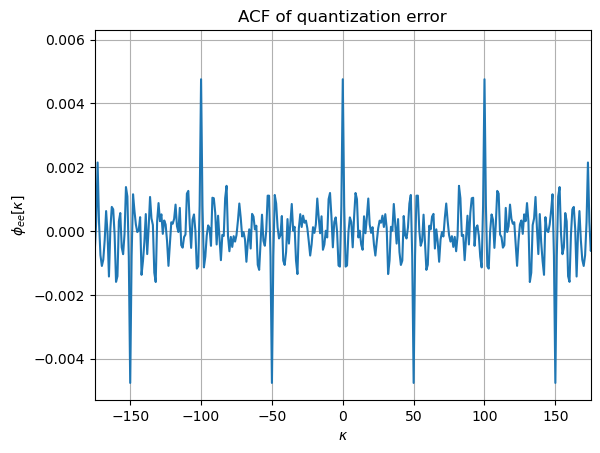

In [8]:
kappa, acf = my_xcorr2(e, e, 'unbiased')
plt.plot(kappa, acf)
plt.xlim(-175, +175)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\phi_{ee}[\kappa]$')
plt.title('ACF of quantization error')
plt.grid(True)

If $e[k]$ would be exactly following the probability density function $p_e(\theta) = \frac{1}{\Delta Q} \mathrm{rect}(\frac{\theta_e}{\Delta Q})$, the auto-correlation function $\phi_{ee}[\kappa]=\delta[\kappa]$ results.

However, this is not observable in this example!

Instead, from the above plot, we can deduce that $e[k]$ is correlated to itself, i.e. it exhibits periodicity each 100 samples in phase, and each 50 sample out of phase.
The sine period is precisely 100 samples, thus the input signal and the quantization error are somewhat linked and not independent.
Thus, the error model assumption is violated. That is bad, since the sine signal allows for otherwise comparable simple analytical calculus.

The links between the signals can be furthermore confirmed with the help of the cross-correlation functions.
Their oscillating characteristics reveal that quantization error is highly correlated.

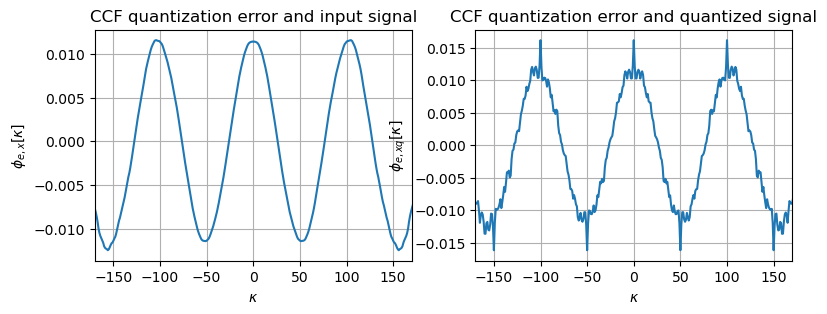

In [9]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
kappa, acf = my_xcorr2(e, x, 'unbiased')
plt.plot(kappa, acf)
plt.xlim(-170, +170)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\phi_{e,x}[\kappa]$')
plt.title('CCF quantization error and input signal')
plt.grid(True)

plt.subplot(1, 2, 2)
kappa, acf = my_xcorr2(e, xq, 'unbiased')
plt.plot(kappa, acf)
plt.xlim(-170, +170)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\phi_{e,xq}[\kappa]$')
plt.title('CCF quantization error and quantized signal')
plt.grid(True)

Therefore, the special case of sine signals is in fact not suited for the quantization model above.
Because of the simplicity of the involved calculation it is common practice to conduct this analysis for sine signals nevertheless, and signal-to-noise ratios in the data sheets of A/D converters are mostly stated for excitation with sine signals.
For random signals, the quantization model is only valid for high levels in the quantizer. For more information see
[Udo Zölzer, Digital Audio Signal Processing, Wiley](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470680018)
(might be available as free access in your uni network)

-  Task:
Increase the (odd) number of quantization steps $Q$ and check what happens with the shape and amplitudes of the correlations functions. Hint: closer look to the amplitudes of the correlation signals.

## Quantization Modeling / Mapping

The mapping of the infinitely large continuous set of values to a discrete number of amplitude steps is realized with a transfer characteristic.
The height of the amplitude steps is $\Delta Q$.



From the lecture, we know that the following mapping is used in order to quantize the continuous amplitude signal $x[k]$

towards

\begin{equation}
x_Q[k] = g( \; \lfloor \, f(x[k]) \, \rfloor \; ),
\end{equation}

where $g(\cdot)$ and $f(\cdot)$ denote real-valued mapping functions, and $\lfloor \cdot \rfloor$ a rounding operation (**not necessarily the plain floor operation**).

### Uniform Saturated Midtread Quantization Characteristic Curve

With the introduced mapping, the uniform saturated midtread quantizer can be discussed.
This is probably the most important curve for uniform quantization due to its practical relevance for coding quantized amplitude values as bits. In general, the uniform midtread quantizer can be given as the mapping

\begin{equation}
x_Q[k] =  \frac{1}{Q \backslash 2} \cdot \lfloor (Q \backslash 2) \cdot x[k]\rfloor,
\end{equation}

where for $\lfloor \cdot \rfloor$ a rounding operation might used and $\backslash$ denotes integer division.
So the mapping functions $g$ and $f$ are simple multiplications.
At the beginning of this notebook, the function `my_quant` is implemented that realizes quantization based on this mapping.
The approach uses `numpy`'s `round` operation.
When asking for rounding, care has to be taken, which [approach](https://en.wikipedia.org/wiki/Rounding) shall be used.
Numpy rounds to the nearest **even** integer in contrast to e.g. Matlab's rounding to nearest integer.

Detailed analysis for `my_quant`:

- the quantization should be properly performed only for $-1 \leq x < 1$
- thus, it always saturates $x<-1$ towards $x_q = -1$
- in the case of an **odd** number of quantization steps $Q$, it saturates $x>+1$ towards $x_q = +1$. The quantization step size is $\Delta Q = \frac{2}{Q-1}$.
- In the case of an **even** number of quantization steps $Q$, it saturates $x>\frac{Q - 1 - \frac{Q}{2}}{\frac{Q}{2}} = 1-\frac{2}{Q}$ towards $x_q = \frac{Q - 1 - \frac{Q}{2}}{\frac{Q}{2}}=1-\frac{2}{Q}$. The quantization step size is $\Delta Q = \frac{2}{Q}$.

### AD / DA Converter Convention

The case of **even** $Q$ is practically used for virtually all analog/digital (AD) and digital/analog (DA) converters.

When additionally to the above statements

\begin{equation}
\log_2(Q)\in\mathbb{N}
\end{equation}

holds, it is meaningful to code the even and power of two $Q$ possible quantization steps with bits.

With $B\in\mathbb{N}$ denoting the number of bits, the number range convention for AD and DA converters is

\begin{equation}
\begin{split}
&-1\leq x \leq 1-2^{-(B-1)}\\
&-1\leq x \leq 1-\frac{2}{Q}
\end{split}
\end{equation}

using

\begin{equation}
Q=2^B
\end{equation}

quantization steps.
Values of $x$ outside this range will be saturated to the minimum $-1$ and maximum $1-\frac{2}{Q}$ quantization values in the quantization process.

For example, $B = 16$ bits are used to code [PCM data for CD](https://en.wikipedia.org/wiki/Compact_disc) audio quality.
Then we get the following quantities.

In [10]:
B = 16  # number of bits
Q = 2**B  # number of quantization steps

# for even Q only:
deltaQ = 2/Q
# maximum quantize value:
xqmax = 1-2**(-(B-1))
# or more general for even Q:
xqmax = 1-deltaQ

print(' B = %d bits\n quantization steps Q = %d\n quantization step size %e' %
      (B, Q, deltaQ))
print(' smallest quantization value xqmin = -1')
print(' largest quantization value xqmax = %16.15f' % xqmax)
# B = 16 bits
# quantization steps Q = 65536
# quantization step size 3.051758e-05
# smallest quantization value xqmin = -1
# largest quantization value xqmax = 0.999969482421875

 B = 16 bits
 quantization steps Q = 65536
 quantization step size 3.051758e-05
 smallest quantization value xqmin = -1
 largest quantization value xqmax = 0.999969482421875


So called high definition audio uses 24 Bit. Video and photo typically uses 8-12 Bit quantization per color channel.

### Plotting the Midtread Curve

We now can visualize the characteristic curve for a simple, made up input signal, i.e. a monotonic increasing signal between $x_{max} = -x_{min}$ using an equidistant increment $\Delta x$ over sample index $k$.

Here, we use $x_{max} = 1.25$ and $\Delta x=0.001$ and assume that we start with $x_{min} = -1.25$ at $k=0$.
If $\Delta x$ is sufficiently small, the signal's amplitude can be interpreted as continuous straight line.
This straight line is degraded in a quantization process.
Plotting the quantization result over the input, results in the characteristic curve, in our example in the curve of the uniform saturated midtread quantizer.

Let us plot this.

**Please note:**
The quantizer `uniform_midtread_quantizer` known from lecture and `my_quant` yield the same results besides a slight detail: `uniform_midtread_quantizer` always exhibits an **even** number of quantization steps $Q$.
So, only for even $Q$ results are exactly identical.

We might verify this in the next plots as well.

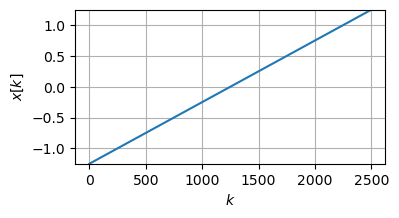

In [11]:
x = np.arange(-1.25, +1.25, 1e-3)
plt.figure(figsize=(4, 2))
plt.plot(x)  # actually a stem plot is correct
plt.ylim(-1.25, +1.25)
plt.xlabel(r'$k$')
plt.ylabel(r'$x[k]$')
plt.grid(True)

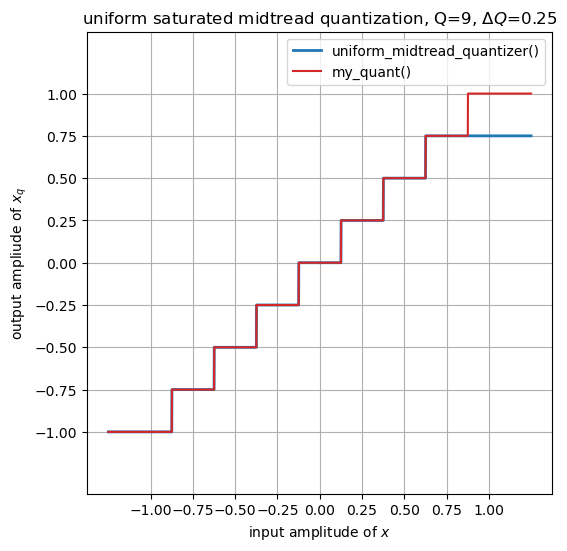

In [12]:
Q = 9  # number of quantization steps, odd or even
deltaQ = 1/(Q//2)  # quantization step size, even/odd Q

xq = my_quant(x, Q)  # used in exercise
xumq = uniform_midtread_quantizer(x, deltaQ)  # as used in lecture

plt.figure(figsize=(6, 6))
plt.plot(x, xumq, 'C0', lw=2, label='uniform_midtread_quantizer()')
plt.plot(x, xq, 'C3', label='my_quant()')
plt.xticks(np.arange(-1, 1.25, 0.25))
plt.yticks(np.arange(-1, 1.25, 0.25))
plt.xlabel(r'input amplitude of $x$')
plt.ylabel(r'output ampliude of $x_q$')
plt.title(
    r'uniform saturated midtread quantization, Q={0:d}, $\Delta Q$={1:3.2f}'.format(Q, deltaQ))
plt.axis('equal')
plt.legend()
plt.grid(True)

The following exercises used to be a homework assignment as exam's prerequisite.

# Exercise 1: Uniform Saturated Midtread Characteristic Curve of Quantization

## Task

Check this quantizer curve for $Q=7$ and $Q=8$.
Make sure that you get the idea of the midtread concept (the zero is always quantized to zero) and saturation (for even $Q$) largest quantization step is saturated).

In [13]:
def check_my_quant(Q):
    N = 5
    r = np.arange(N)
    x = np.power(r, 3)
    xq = my_quant(x, Q)
    e = xq - x

    plt.xlim(-5, 5)
    plt.ylim(-10, 10)
    plt.plot(r, x, color='C2', lw=3, label=r'$x[k]$')
    plt.plot(r, xq, color='C3', label=r'$x_q[k]$')
    plt.plot(r, e, color='C0', label=r'$e[k] = x_q[k] - x[k]$')
    plt.xlabel('input amplitude')
    plt.ylabel('output amplitude')
    if np.mod(Q, 2) == 0:
        s = ' saturated '
    else:
        s = ' '
    plt.title(
        'uniform'+s+'midtread quantization with Q=%d steps, $\Delta Q$=%4.3e' % (Q, 1/(Q//2)))
    plt.axis('equal')
    plt.legend(loc='upper left')
    plt.grid(True)

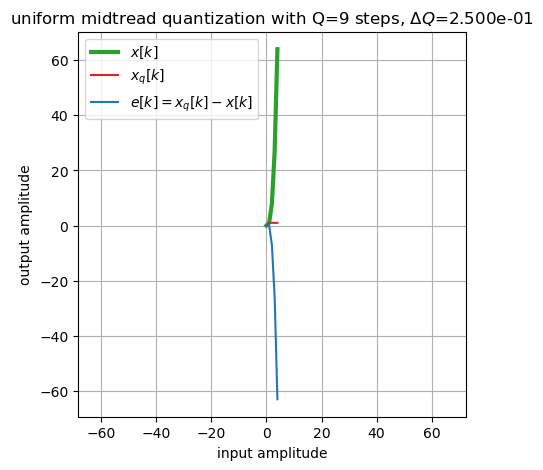

In [14]:
Q = 9  # number of quantization steps
deltaQ = 1 / (Q//2)  # general rule
deltaQ = 2 / (Q-1)  # for odd Q only
plt.figure(figsize=(5, 5))
check_my_quant(Q)

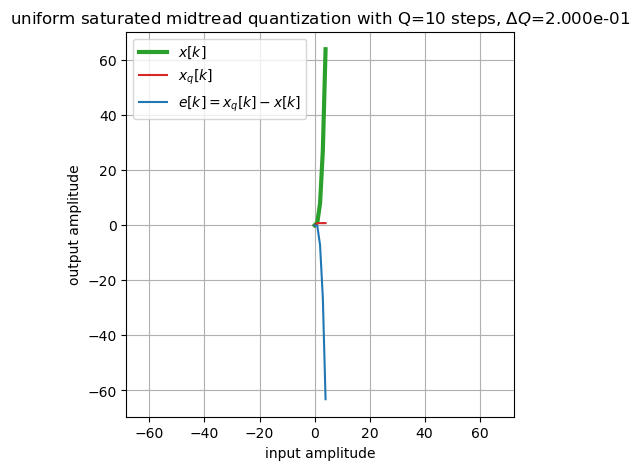

In [15]:
Q = 10  # number of quantization steps
deltaQ = 1 / (Q//2)  # general rule
deltaQ = 2 / Q  # for even Q only
plt.figure(figsize=(5, 5))
check_my_quant(Q)